In [1]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters
import scipy.ndimage

import sys
sys.path.append(r'../src/')

import importlib
import transform
import filters
import local_radon
import skew_line
importlib.reload(transform)
importlib.reload(filters)
importlib.reload(local_radon)
importlib.reload(skew_line)

<module 'skew_line' from '../src\\skew_line.py'>

D:/Data/bujo_sample\20190309_125151.jpg


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Text angles is 0.0
Text line delta is 9
Wall time: 1.78 s


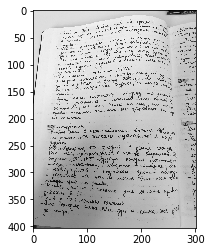

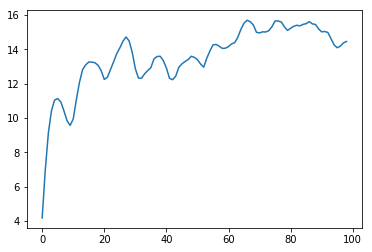

In [2]:
%%time
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[6])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

src2 = skimage.transform.rescale(src, scale=0.05)

text_angle = transform.get_text_angle(src2)
print('Text angles is {}'.format(text_angle[0][0]))

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.1), -90.0-text_angle[0][0], resize=True)
plt.figure()
plt.imshow(src3, cmap='gray')

text_line_delta, text_line_deltas = transform.get_text_line_delta(src3)
plt.figure()
plt.plot(text_line_deltas)
print('Text line delta is {}'.format(text_line_delta))

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[(-1.5466302294595904, -64.0, 0, 162, 1677)]
Wall time: 202 ms


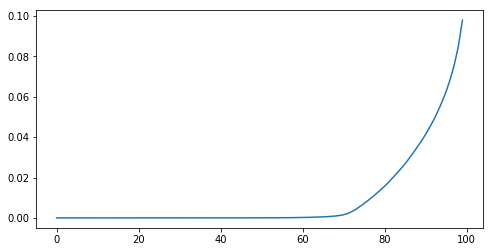

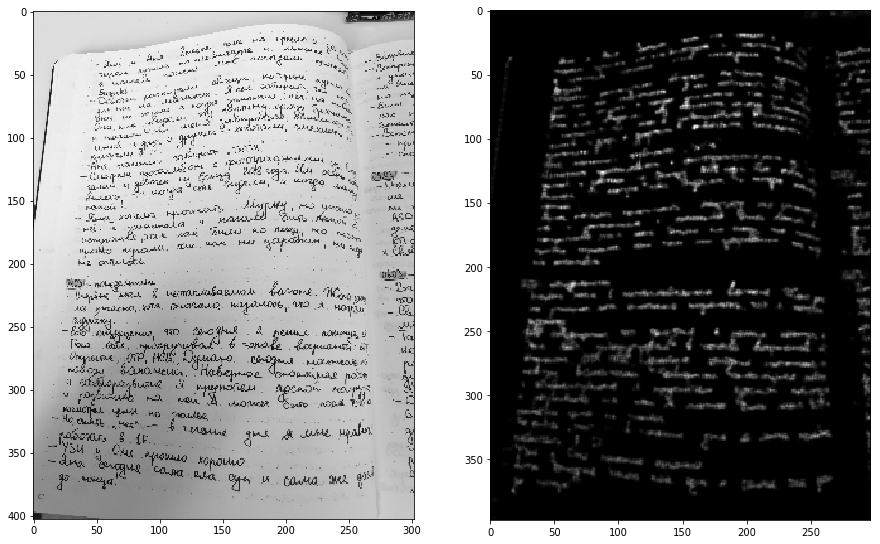

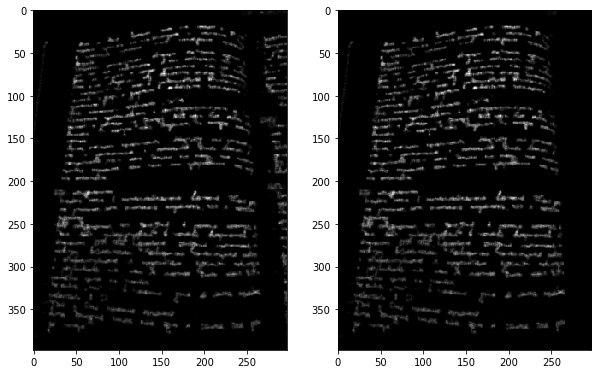

In [3]:
%%time
src4 = transform.filter_variance(src3, (text_line_delta//2, text_line_delta//2), 50, 50)
text_cutoff = np.percentile(src4, 90)/2

src5 = skimage.transform.rescale(src4>text_cutoff, scale=0.25)>0.0
src6 = skimage.filters.gaussian(src5, sigma=0.2)>0.4

vsplits = transform.search_region_vsplit(src6, np.pi*3/8, num_angles=131,
                                         window_size_1d=15, max_value=2, zero_threshold=10,
                                         min_split_abs=100, max_split_pct=0.10)

src7 = transform.erase_regions(src4, vsplits, dsz=4)


plt.figure(figsize=(8,4))
plt.plot(np.percentile(src4, range(100)))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(src3, cmap='gray')
plt.subplot(122)
plt.imshow(src4, cmap='gray')

print(vsplits)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(src4, cmap='gray')
plt.subplot(122)
plt.imshow(src7, cmap='gray')

In [ ]:
%%time
src8 = filters.local_maxima_v(src7, 1, text_line_delta//2, text_cutoff)*1.0

curves = skew_line.create_support_curves(src8, 20, (40, 50))

ires, imeta = skew_line.integrate_curves(src8, curves)
ids = skew_line.select_line_candidates(ires, text_line_delta//2, min_value=20, minmax_ratio=0.8)

all_curves = []
for i in ids:
    if len(imeta[i])>2:
        tmp_j, tmp_i = skew_line.interpolate_between_curves(np.arange(src8.shape[1]), 0, src8.shape[0]-1, imeta[i][0], imeta[i][1], imeta[i][2])
    else:
        tmp_j, tmp_i = skew_line.offset_curve(np.arange(src8.shape[1]), imeta[i][0], imeta[i][1])
        
    all_curves.append((tmp_j, tmp_i))
    plt.plot(tmp_j, tmp_i)

plt.figure(figsize=(8,20))
plt.subplot(211)
plt.imshow(src8, cmap='gray')
for crv in curves:
    plt.plot(crv[:,1], crv[:,0])
    
plt.subplot(212)
plt.plot(ires)
for i in ids:
    plt.plot(i, ires[i], 'bo')